https://www.kaggle.com/code/husnifadhilah/building-a-transformer-gpt-from-scratch

code adpoted from https://www.kaggle.com/code/kevinbnisch/building-a-transformer-gpt-from-scratch

In [1]:
import torch, nltk, os, re, math
import pandas as pd
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.nn import functional as F

nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
# ========== Hyperparameters
batch_size = 64
block_size = 256 # We will predict the 257 token on the basis of the 256 before that now!
max_iters = 50000
eval_interval = 500
learning_rate = 3e-4 # Bring down the learning rate
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 384 # 384 / 6 = 64
n_head = 6
n_layer = 4
dropout = 0.2
output_dir = "/kaggle/working/"
# ==========================
torch.manual_seed(1337)

In [3]:
df = pd.read_csv('/kaggle/input/dataset-pantun-indonesia/dataset-pantun.csv')
df = df[['teks','tipe']]
df

,teks,tipe
0,Ada motor ada sepeda \n Semuanya beroda dua \n...,Pantun Adat dan Alam
1,Ada pisang ada semangka \n Jika dimakan manis ...,Pantun Adat dan Alam
2,Ada rusa ada buaya \n Sungguh hitam warna mata...,Pantun Adat dan Alam
3,Alat timbang pucuknya patah \n Beli baru henda...,Pantun Adat dan Alam
4,Anak cina makan petai \n Kakinya terikat ranta...,Pantun Adat dan Alam
...,...,...
1445,Jalan-jalan ke surabaya \n Pulangnya beli hadi...,NaN
1446,Hari malam gelap-gelita \n Pasang lilin jalan ...,NaN
1447,Apa guna berkain batik \n Kalau tidak dengan s...,NaN
1448,Buah cempedak di luar pagar \n Ambil galah tol...,NaN


In [4]:
# Replace '\n' with true line breaks
# df['teks'] = df['teks'].str.replace('\\n', '\n')
# Add two empty lines between rows
# df['teks'] = df['teks'].apply(lambda x: x + '\n\n')
# df['teks'] = df['teks'].apply(preprocess_text)
# Combine all texts into one complete text with three empty lines between each row
text = '\n\n'.join(df['teks'])
text[:250]

'Ada motor ada sepeda \\n Semuanya beroda dua \\n Indonesia kaya budaya \\n Sepatutnya kita menjaganya\n\nAda pisang ada semangka \\n Jika dimakan manis rasanya \\n Indonesia ragam budaya \\n Tugas kita tuk menjaganya\n\nAda rusa ada buaya \\n Sungguh hitam warn'

In [5]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !&'(),-/01245789:?ABCDEFGHIJKLMNOPQRSTUVWXYZ\abcdefghijklmnopqrstuvwxyz–
74


In [6]:
# Tokenizer
chars = sorted(list(set(text)))
vocab_size = len(chars)
lookup_table_in = { ch:i for i,ch in enumerate(chars)}
lookup_table_out = { i:ch for i,ch in enumerate(chars)}
encode = lambda s: [lookup_table_in[c] for c in s] # Encoder
decode = lambda l: ''.join([lookup_table_out[i] for i in l]) # Decoder
data = torch.tensor(encode(text), dtype=torch.long)

# Train and Test Split
n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]

# Data Loading
def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

# Loss
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [7]:
# =========== Transformer Components:

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        
        self.dropout = nn.Dropout(dropout) # <----- Added Dropout!

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei) # <------ Added Dropout!
        v = self.value(x)
        out = wei @ v
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        # Added the possibility to add heads per parameter and loop. That's it.
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout) # <----- More Dropout!

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out)) # <----- More Dropout!
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout), # <----- More Dropout!
        )

    def forward(self, x):
        return self.net(x)
    
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

# We now don't have a BigramLanguage anymore
class GPTLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        # Added the possibility to add heads per parameter and loop. That's it.
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device))
        x = tok_emb + pos_emb
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, loss = self(idx_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

In [8]:
# Train =============================
model = GPTLanguageModel()
model = model.to(device)
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
# print the number of parameters in the model
print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')
print(model)

7.249226 M parameters
GPTLanguageModel(
  (token_embedding_table): Embedding(74, 384)
  (position_embedding_table): Embedding(256, 384)
  (blocks): Sequential(
    (0): Block(
      (sa): MultiHeadAttention(
        (heads): ModuleList(
          (0-5): 6 x Head(
            (key): Linear(in_features=384, out_features=64, bias=False)
            (query): Linear(in_features=384, out_features=64, bias=False)
            (value): Linear(in_features=384, out_features=64, bias=False)
            (dropout): Dropout(p=0.2, inplace=False)
          )
        )
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (ffwd): FeedFoward(
        (net): Sequential(
          (0): Linear(in_features=384, out_features=1536, bias=True)
          (1): ReLU()
          (2): Linear(in_features=1536, out_features=384, bias=True)
          (3): Dropout(p=0.2, inplace=False)
        )
      )
      (ln1): LayerNorm((384,), eps=1e-0

step 0: train loss 4.4435, val loss 4.4451
step 500: train loss 1.8036, val loss 1.8113
step 1000: train loss 1.4681, val loss 1.5643
step 1500: train loss 1.2078, val loss 1.4555
step 2000: train loss 0.9917, val loss 1.4627
step 2500: train loss 0.7764, val loss 1.5588
step 3000: train loss 0.5749, val loss 1.6964
step 3500: train loss 0.4046, val loss 1.8775
step 4000: train loss 0.2725, val loss 2.0599
step 4500: train loss 0.1936, val loss 2.2644
step 5000: train loss 0.1445, val loss 2.4214
step 5500: train loss 0.1113, val loss 2.6197
step 6000: train loss 0.0929, val loss 2.7179
step 6500: train loss 0.0828, val loss 2.8372
step 7000: train loss 0.0759, val loss 2.9771
step 7500: train loss 0.0725, val loss 3.0356
step 8000: train loss 0.0697, val loss 3.1447
step 8500: train loss 0.0674, val loss 3.1926
step 9000: train loss 0.0661, val loss 3.2725
step 9500: train loss 0.0639, val loss 3.3272
step 10000: train loss 0.0632, val loss 3.3715
step 10500: train loss 0.0615, val lo

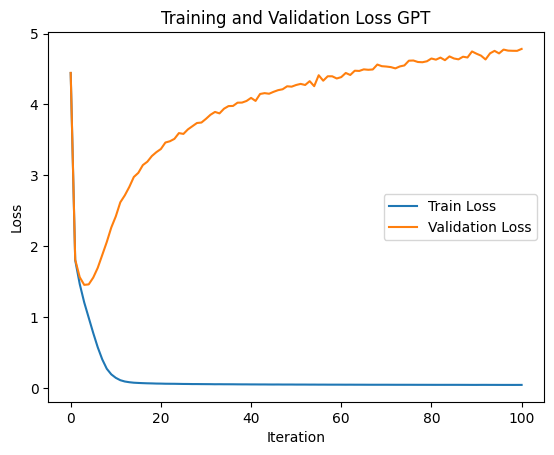

In [9]:
# Lists to store training and validation losses
train_losses = []
val_losses = []

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

        # Append the losses to the respective lists
        train_losses.append(losses['train'])
        val_losses.append(losses['val'])

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# Plotting
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training and Validation Loss GPT')
plt.legend()
plt.savefig('loss_plot.png')
plt.show()

In [10]:
# generate from the model
torch.save(model.state_dict(), 'model.pth')
context = torch.zeros((1, 1), dtype=torch.long, device=device)
generated_poems = decode(model.generate(context, max_new_tokens=1000)[0].tolist())
with open(os.path.join(output_dir, 'generated_poems.txt'), "w") as outfile:
    outfile.write(generated_poems)
print(generated_poems)


Pagi-pagi membeli jamu \n Disimpan di atas kertas \n Jangan bosan menuntut ilmu \n Agar jadi anak yang cerdas

Pagi-pagi membeli jamu \n Jamu disimpan di atas kertas \n Jangan bosan menuntut ilmu \n Agar jadi anak yang cerdas

Pagi-pagi membeli jamu \n Jamu disimpan di atas kertas \n Jangan bosan menuntut ilmu \n Agar jadi anak yang cerdas

Ke pasar membeli duku \n Uangnya hendak diantar \n Jangan lupa harus dibayar \n Kalau ingin jadi dokter \n Sungguh indah kota Sumedan \n Kota suka bersudah bertawa \n Senang sakyit memiliki ribuang \n Nanti bernasib malang \n Sebab cantik di meraih minggu \n Selamat HUT RI yang ke 72 \n Semoga Indonesia tetap bersatu

Sakit kaki ditikam jeruju \n Jeruju ada di dalam paya \n Sakit hati memandang susu \n Susu ada dalam kebaya

Banyak orang menggali perigi \n Ambil buluh kemudian diikat \n Ilmu dicari tak akan rugi \n Untuk bekal dunia akhirat

Empek-empek bumbu cuka \n Lezat sekali dirasa lidah \n Ke kota aku sangat suka \n Ke desa pun banyak yang in

In [11]:
def lexical_richness(text):
    tokens = nltk.word_tokenize(text.lower())
    if len(tokens) == 0:
        return 0  # Mengembalikan 0 jika tidak ada token
    unique_tokens = set(tokens)
    return (len(unique_tokens) / len(tokens)) * 100


def calculate_richness_score(pantun_list):
    richness_scores = [lexical_richness(pantun) for pantun in pantun_list]
    return sum(richness_scores) / len(richness_scores)

def calculate_structure_accuracy(pantun_list):
    correct_structure_count = 0
    total_pantun_count = len(pantun_list)
    for pantun in pantun_list:
        # Check if the pantun has correct structure
        if len(pantun.split('\\n')) == 4:
            correct_structure_count += 1
    structure_accuracy = correct_structure_count / total_pantun_count*100
    return structure_accuracy

def rhyme_check(pantun):
    # Memisahkan setiap baris pantun
    lines = pantun.split("\\n")
    
    # Mengambil kata terakhir dari setiap baris (jika ada)
    last_words = [line.split()[-1].lower() if line.strip() else "" for line in lines]
    
    # Mendefinisikan fungsi untuk mendapatkan vokal terakhir dari setiap kata
    def get_last_vowel(word):
        vowels = "aiueo"
        for char in reversed(word):
            if char.lower() in vowels:
                return char.lower()
        return None
    
    # Mendapatkan vokal terakhir dari setiap kata
    last_vowels = [get_last_vowel(word) for word in last_words]
    
    # Memeriksa kecocokan rima
    if len(last_vowels) == 4 and last_vowels[0] == last_vowels[2] and last_vowels[1] == last_vowels[3]:
        return 1
    else:
        return 0
    
def calculate_rhyme_correctness(pantuns):
    total_pantuns = len(pantuns)
    total_correct = 0
    
    for pantun in pantuns:
        if rhyme_check(pantun):
            total_correct += 1
    
    rhyme_correctness = (total_correct / total_pantuns) * 100
    return rhyme_correctness

In [12]:
# Membaca teks dari file
file_path = "/kaggle/working/generated_poems.txt"  # Ubah sesuai dengan path file Anda
with open(file_path, "r") as file:
    pantun_text = file.read()

# Memisahkan teks menjadi list tanpa karakter "\n"
pantun_list = pantun_text.split('\n\n')
pantun_list = list(filter(None, pantun_list))
# pantun_list = [pantun for pantun in pantun_list if pantun.strip()]
# pantun_list = ["".join(pantun.split("\n")) for pantun in pantun_list]
# Menampilkan pantun dalam bentuk list
print(pantun_list)

['\nPagi-pagi membeli jamu \\n Disimpan di atas kertas \\n Jangan bosan menuntut ilmu \\n Agar jadi anak yang cerdas', 'Pagi-pagi membeli jamu \\n Jamu disimpan di atas kertas \\n Jangan bosan menuntut ilmu \\n Agar jadi anak yang cerdas', 'Pagi-pagi membeli jamu \\n Jamu disimpan di atas kertas \\n Jangan bosan menuntut ilmu \\n Agar jadi anak yang cerdas', 'Ke pasar membeli duku \\n Uangnya hendak diantar \\n Jangan lupa harus dibayar \\n Kalau ingin jadi dokter \\n Sungguh indah kota Sumedan \\n Kota suka bersudah bertawa \\n Senang sakyit memiliki ribuang \\n Nanti bernasib malang \\n Sebab cantik di meraih minggu \\n Selamat HUT RI yang ke 72 \\n Semoga Indonesia tetap bersatu', 'Sakit kaki ditikam jeruju \\n Jeruju ada di dalam paya \\n Sakit hati memandang susu \\n Susu ada dalam kebaya', 'Banyak orang menggali perigi \\n Ambil buluh kemudian diikat \\n Ilmu dicari tak akan rugi \\n Untuk bekal dunia akhirat', 'Empek-empek bumbu cuka \\n Lezat sekali dirasa lidah \\n Ke kota aku

In [13]:
average_richness_score = calculate_richness_score(pantun_list)
print(f"Average Lexical Richness Score: {average_richness_score:.2f}%")

accuracy_score = calculate_structure_accuracy(pantun_list)
print(f"Structure Accuracy Score: {accuracy_score:.2f}%")

rhyme_correctness = calculate_rhyme_correctness(pantun_list)
print(f"Persentase Rhyme Correctness Score: {rhyme_correctness:.2f}%")

Average Lexical Richness Score: 82.88%
Structure Accuracy Score: 85.71%
Persentase Rhyme Correctness Score: 71.43%


In [14]:
model = GPTLanguageModel()
model = model.to(device)
model.load_state_dict(torch.load('/kaggle/working/model.pth', map_location=device))

<All keys matched successfully>

In [15]:
import math

# Setelah iterasi pelatihan
losses = estimate_loss()
train_loss = losses['train']
val_loss = losses['val']

# Hitung perplexity untuk data validasi
val_cross_entropy = val_loss  # Entropi silang pada data validasi
val_perplexity = math.exp(val_cross_entropy)  # Perplexity pada data validasi

print(f"Validation Perplexity: {val_perplexity:.4f}")

Validation Perplexity: 115.9674
